## RNN predicting precipitation with other Datasets
**Jena Climate Dataset**

In [27]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, SimpleRNN, LSTM, GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
file_path = 'jena_climate_2009_2016.csv'
data = pd.read_csv(file_path)
# Dataset itself is significantly (450k+ samples) we will just do the first 10,000 samples
subset_size = 10000
jena_data = data.iloc[:subset_size].copy()

print(jena_data.head())

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

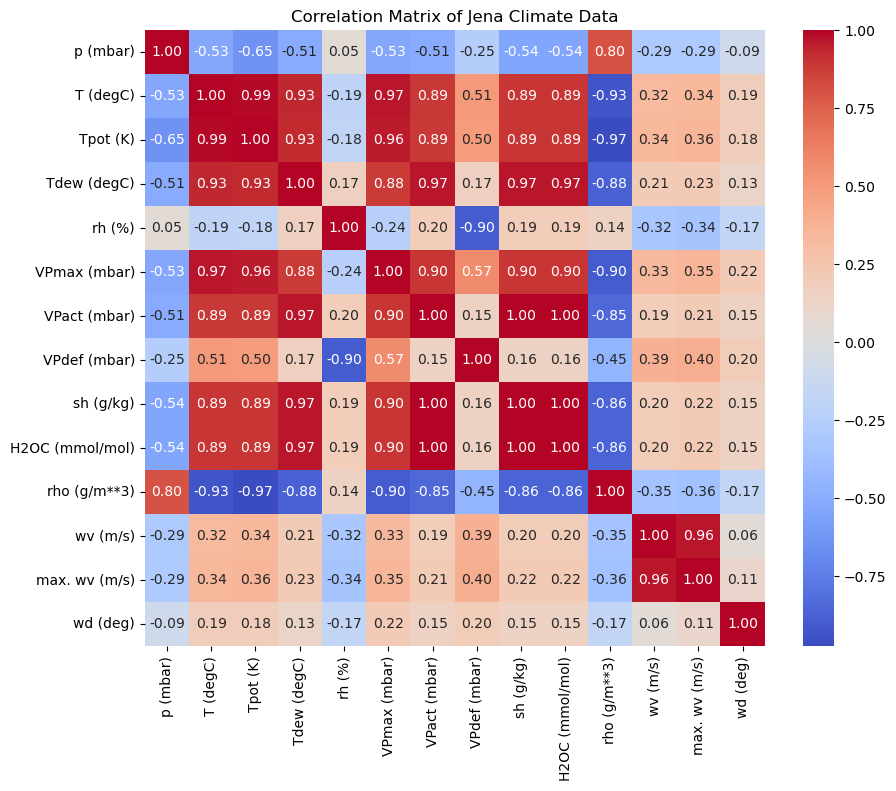

In [29]:
# Ignore non number data
numeric_data = jena_data.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Jena Climate Data")
plt.show()

**Theres likely redundant features that may impact the model, well drop them later**

<Axes: xlabel='Date Time'>

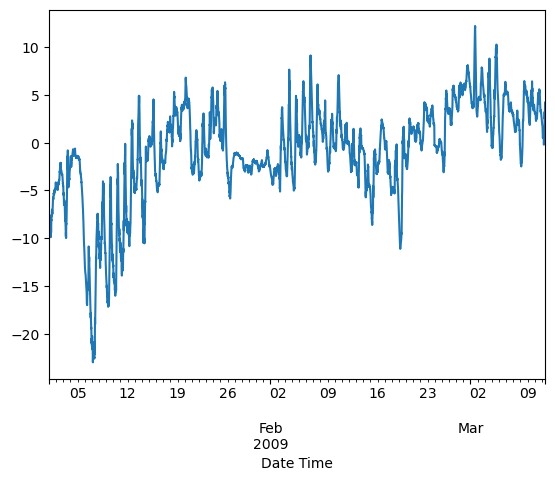

In [30]:
jena_data.index = pd.to_datetime(jena_data['Date Time'], format='%d.%m.%Y %H:%M:%S')
temp = jena_data['T (degC)']
temp.plot()

In [31]:
# Select features and target
# Excluding redundant features that may impact model
features = ['p (mbar)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 
            'VPact (mbar)', 'sh (g/kg)', 'rho (g/m**3)']
target = 'T (degC)'

# Normalize features and the target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

jena_data[features] = scaler_features.fit_transform(jena_data[features])
jena_data[target] = scaler_target.fit_transform(jena_data[[target]])

# Create sequences for the RNN
seq_length = 7  # Use the past 7 days
X, y = [], []

for i in range(len(jena_data) - seq_length):
    X.append(jena_data[features].iloc[i:i+seq_length].values) 
    y.append(jena_data[target].iloc[i+seq_length])  # Target 

X = np.array(X)
y = np.array(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Build RNN Model
rnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(32, activation='tanh', return_sequences=True),  # First RNN layer
    Dropout(0.3), # to reduce overfitting
    SimpleRNN(16, activation='tanh', return_sequences=False),  # Second RNN layer
    Dropout(0.3),
    Dense(1)  # Output layer, for regression
])

# Compile
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print(rnn_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 7, 32)               │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,113 (8.25 KB)

 Trainable params: 2,113 (8.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [33]:
# Train the model
history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4673 - mae: 0.5284 - val_loss: 0.0035 - val_mae: 0.0447
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0829 - mae: 0.2266 - val_loss: 8.4595e-04 - val_mae: 0.0224
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0389 - mae: 0.1572 - val_loss: 9.8850e-04 - val_mae: 0.0213
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0232 - mae: 0.1191 - val_loss: 0.0013 - val_mae: 0.0256
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0174 - mae: 0.1044 - val_loss: 7.7768e-04 - val_mae: 0.0172
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136 - mae: 0.0918 - val_loss: 7.6937e-04 - val_mae: 0.0227
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0103 - mae: 0.0793 - val_loss: 3.2673e-04 - val_mae: 0.0116
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084 - mae: 0.0716 - val_loss: 3.6957e-04 - val_mae: 0.0155
Epoch 9/50
200/200 ━━━━━━━━━━━━━

In [34]:
test_loss, test_mae = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

y_pred = rnn_model.predict(X_test)

y_pred_original = scaler_target.inverse_transform(y_pred)
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

Test Loss (MSE): 0.0001
Test MAE: 0.0053
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


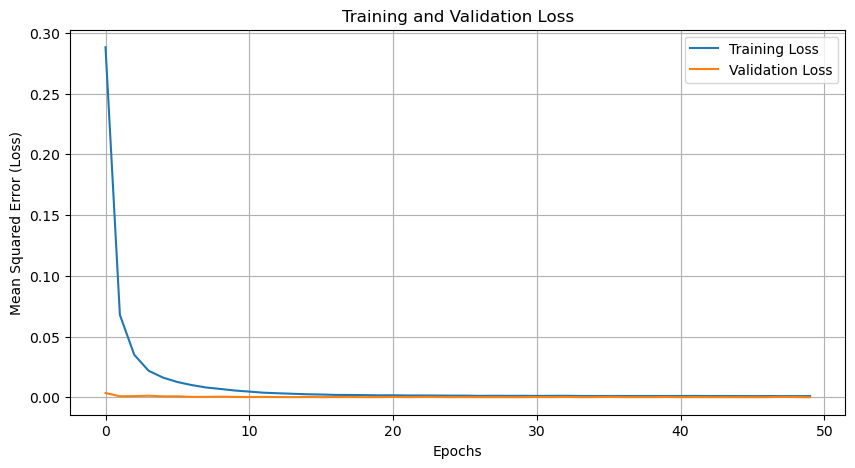

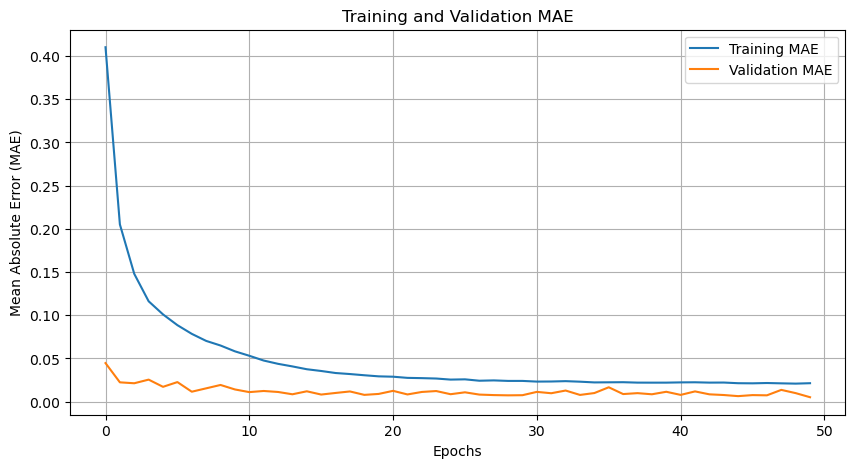

In [35]:
# Plotting MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

   Actual Temperature (degC)  Predicted Temperature (degC)
0                       0.35                      0.549965
1                     -12.10                    -11.668097
2                       0.72                      0.806398
3                      -8.13                     -8.333699
4                      -1.99                     -2.079264


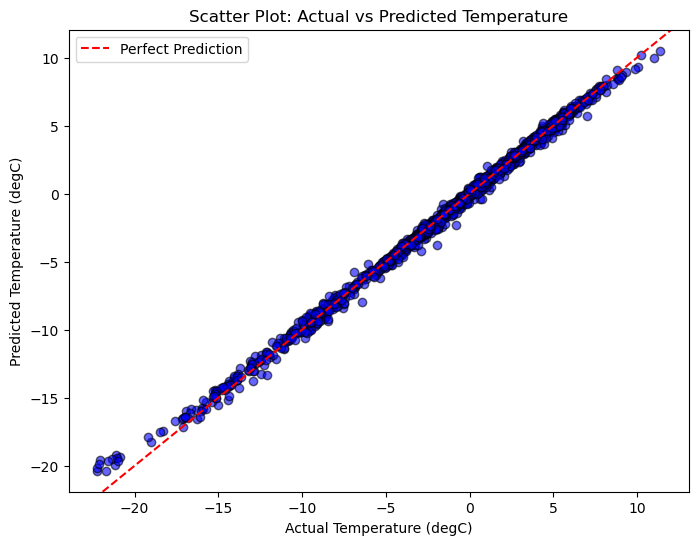

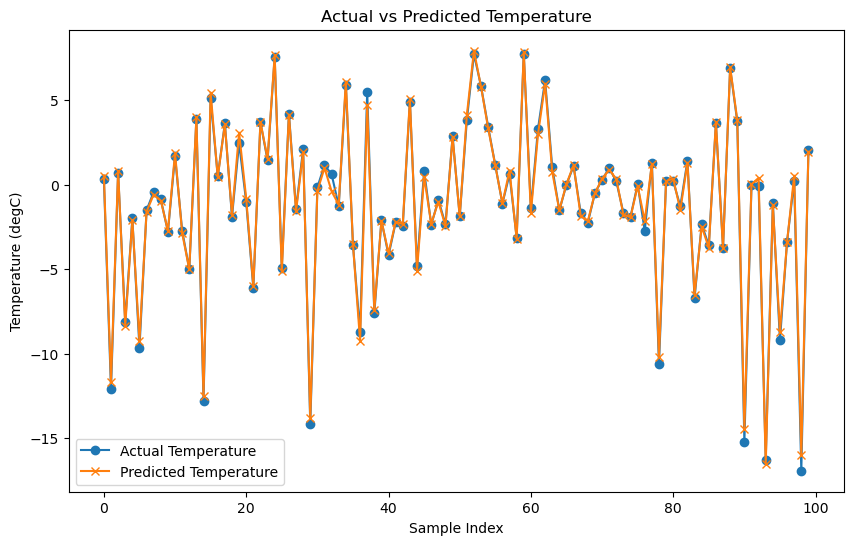

In [38]:
# Flatten the arrays to ensure they are 1-dimensional
y_test_original_flat = y_test_original.flatten()
y_pred_original_flat = y_pred_original.flatten()

# Create the DataFrame
comparison_df = pd.DataFrame({
    'Actual Temperature (degC)': y_test_original_flat,
    'Predicted Temperature (degC)': y_pred_original_flat
})
print(comparison_df.head())

# Scatter plot for actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original_flat, y_pred_original_flat, alpha=0.6, color='blue', edgecolors='k')
plt.title('Scatter Plot: Actual vs Predicted Temperature')
plt.xlabel('Actual Temperature (degC)')
plt.ylabel('Predicted Temperature (degC)')
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label='Actual Temperature', marker='o')
plt.plot(y_pred_original[:100], label='Predicted Temperature', marker='x')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()


## **The same RNN model performs exremely well with this dataset likely due to the following:**
- **Stronger correlations for the model to learn from in this larger dataset**
- **This dataset has different features that also may present stronger relationships for the model to learn from**
- **TLDR more data wtih good correlations improves the RNN models ability to learn the temporal relationshps**
- **Significant feature engineering or other edata augmentation techniques may need to be applied for the smaller dataset for a equivalent performance**